In [11]:
import pandas as pd
import numpy as np
import jieba
import re
import gensim
import time
import multiprocessing
from tqdm import tqdm_notebook
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

import matplotlib.pyplot as plt
%matplotlib inline

new_words = "花呗 借呗 蚂蚁花呗 蚂蚁借呗 蚂蚁森林 小黄车 飞猪 微客 宝卡 芝麻信用 亲密付 淘票票 饿了么 摩拜 滴滴 滴滴出行".split(" ")
for word in new_words:
    jieba.add_word(word)

star = re.compile("\*+")

# df = pd.read_csv("data/atec_nlp_sim_train.csv",encoding="utf8",sep="\t",header=None)
# df.set_index(0,inplace=True)
# for i in range(1, len(df)+1):
#     df.loc[i,4] = synonyms.compare(df.loc[i,1], df.loc[i,2])

lines1 = open("data/atec_nlp_sim_train.csv","r",encoding="utf8").readlines()
lines2 = open("data/atec_nlp_sim_train_add.csv","r",encoding="utf8").readlines()

with open("data/atec_nlp_sim_test.csv","w",encoding="utf8") as f:
    for line in lines1:
        lineno, s1, s2, label=line.strip().split("\t")
        f.write("\t".join([lineno,s1,s2])+"\n")
        
with open("data/atec_nlp_sim_test_add.csv","w",encoding="utf8") as f:
    for line in lines2:
        lineno, s1, s2, label=line.strip().split("\t")
        f.write("\t".join([lineno,s1,s2])+"\n")
        

with open("data/atec_nlp_sim_train_pos.csv","w",encoding="utf8") as f1, open("data/atec_nlp_sim_train_neg.csv","w",encoding="utf8") as f2:
    for line in lines1:
        lineno, s1, s2, label=line.strip().split("\t")
        if label == "1":
            f1.write("\t".join([lineno,s1,s2])+"\n")
        else:
            f2.write("\t".join([lineno,s1,s2])+"\n")

vocab = {}

for line in lines1+lines2:
    lineno, s1, s2, label=line.strip().split("\t")
    
    for word in list(jieba.cut(star.sub("1",s1))) + list(jieba.cut(star.sub("1",s2))):
        vocab[word] = vocab.setdefault(word,0) + 1

vocablist = [(k,v) for k,v in vocab.items()]
vocablist.sort(key=lambda x:x[1], reverse=True)

totalword = sum([c[1] for c in vocablist ])
print(totalword)
word_freq = {k:v/totalword for k,v in vocablist}

open("model/word_freq.txt","w",encoding="utf8").write("\n".join([k+"\t"+str(v) for k,v in word_freq.items()]))

word_freq = {kv.split("\t")[0]:(kv.split("\t")[1]) for kv in open("model/word_freq.txt","r",encoding="utf8").read().split("\n")}

print(len(vocablist))
print(vocablist[:100])

lineno, s1, s2, label = lines2[0].strip().split("\t")
list(jieba.cut(s1))

print(s2)
list(jieba.cut(s2))



vocab = {}
for line in sentences:
    for word in line:
        vocab[word] = vocab.setdefault(word,0) + 1
len(vocab)

model = gensim.models.Word2Vec.load("model/word2vec_gensim")

model.wv.similar_by_word("淘宝")

len(model.wv.vocab)

model.wv.vocab["微信"].index
model.wv.vocab["淘宝"].index

model.wv.vocab["微信"].sample_int
model.wv.vocab["淘宝"].sample_int

model.wv.vocab["微信"].count
model.wv.vocab["淘宝"].count
# ("微信")
# model.wv.word_vec["微信"]

total = sum([v for k,v in vocab.items()])

def sentence_to_vec(sentence_list, embedding_size=100, total=1e8, a=1e-3):
    total = model.wv.vocab["淘宝"].sample_int
    sentence_set = []
    for sentence in sentence_list:
        vs = np.zeros(embedding_size)  # add all word2vec values into one vector for the sentence
        sentence_length = len(sentence)
        for word in sentence:
            try:
                a_value = a / (a + model.wv.vocab[word].count/total)  # smooth inverse frequency, SIF
                vs = np.add(vs, np.multiply(a_value, model.wv[word]))  # vs += sif * word_vector
            except:
                a_value = 1
                vs = np.add(vs, np.zeros(embedding_size))

        vs = np.divide(vs, sentence_length)  # weighted average
        sentence_set.append(vs)  # add to our existing re-calculated set of sentences

    # calculate PCA of this sentence set
    pca = PCA(n_components=embedding_size)
    pca.fit(np.array(sentence_set))
    u = pca.components_[0]  # the PCA vector
    u = np.multiply(u, np.transpose(u))  # u x uT

    # pad the vector?  (occurs if we have less sentences than embeddings_size)
    if len(u) < embedding_size:
        for i in range(embedding_size - len(u)):
            u = np.append(u, 0)  # add needed extension for multiplication below

    # resulting sentence vectors, vs = vs -u x uT x vs
    sentence_vecs = []
    for vs in sentence_set:
        sub = np.multiply(u, vs)
        sentence_vecs.append(np.subtract(vs, sub))

    return sentence_vecs

# total_a = [(np.power(10.,total), 1/np.power(10.,a)) for a in range(3,10,3) for total in range(5,15,4)]
# for total,a in total_a:
#     print("condition:",total,a)

train_lines,test_lines = train_test_split(lines1 + lines2,test_size=0.3,random_state=13 )

e = np.zeros((len(test_lines),2))

sentences = []
labels = []
end = 0
batch_size = 10000
for i,line in tqdm_notebook(enumerate(test_lines)):
    lineno, s1, s2, label=line.strip().split("\t")    
    sentences.append(list(jieba.cut(star.sub("1",s1))) )
    sentences.append(list(jieba.cut(star.sub("1",s2))) )
    labels.append(label)
    if (i+1) % batch_size == 0:
        sentence_vecs = sentence_to_vec(sentences)
        for j in range(len(sentences)//2):
            sim = cosine_similarity([sentence_vecs[j*2]], [sentence_vecs[j*2 + 1]])
            e[end+j] = (sim[0][0],labels[j])
        end = i+1
        sentences = []
        labels = []

if sentences:
    sentence_vecs = sentence_to_vec(sentences)
    for j in range(len(sentences)//2):
        sim = cosine_similarity([sentence_vecs[j*2]], [sentence_vecs[j*2 + 1]])
        e[end+j] = (sim[0][0],labels[j])
    sentences = []
    labels = []

# 评估相关性
f = pd.DataFrame(e)
m1,m2,fact = 0,99,100

print(f.corr())
x = np.array([f1_score(y_pred=f.loc[:,0]>thr/fact, y_true=f.loc[:,1]) for thr in range(m1,m2)])
print(list(range(m1,m2))[x.argmax()]/fact)

plt.plot(x)
# word2vec_v1   0.39712386
# word2vec_v2   0.35729799

print(chr(0x4E00))



s:\servers\python36\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


# 拼音模型

In [ ]:
import pinyin
print(pinyin.get('你 好'))
print(pinyin.get('你好', format="strip", delimiter=" "))
print (pinyin.get('你好', format="numerical", delimiter=" "))
print (pinyin.get_initial('你好'))
pinyin.pinyin.pinyin_dict, 
pinyin.pinyin.pinyin_tone,
len(set(pinyin.pinyin.pinyin_dict.values())),
set(pinyin.pinyin.pinyin_tone.values())


# simaese model

In [ ]:
import pandas as pd
import os
import numpy as np
import re
from tqdm import tqdm_notebook

from keras.preprocessing.sequence import pad_sequences
from keras.models import Model,Sequential
from keras.layers import Input, Embedding, LSTM, Merge,Dropout,Bidirectional,CuDNNLSTM,CuDNNGRU
import keras.backend as K
from keras.optimizers import Adadelta,SGD,Adam
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

import gensim
import jieba

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

import matplotlib.pyplot as plt
%matplotlib inline

from simaese import get_model,f1

# model = gensim.models.Word2Vec.load("submits/word2vec_1.0/model/word2vec_gensim")
model = gensim.models.Word2Vec.load("model/word2vec_gensim256")
word2index = {v:k for k,v in enumerate(model.wv.index2word)}

open("model/word2index.txt","w",encoding="utf8").write("\n".join([k+"\t"+str(v) for k,v in word2index.items()]))

word2index = {kv.split("\t")[0]:(kv.split("\t")[1]) for kv in open("model/word2index.txt","r",encoding="utf8").read().split("\n")}



lines1 = open("data/atec_nlp_sim_train.csv","r",encoding="utf8").readlines()
lines2 = open("data/atec_nlp_sim_train_add.csv","r",encoding="utf8").readlines()

data_l_n = []
data_r_n = []
y = []
for line in lines1+lines2:
    lineno, s1, s2, label=line.strip().split("\t")
    data_l_n.append([word2index[word] for word in list(jieba.cut(star.sub("1",s1))) if word in word2index]) 
    data_r_n.append([word2index[word] for word in list(jieba.cut(star.sub("1",s2))) if word in word2index])
    y.append(int(label))
# 对齐语料中句子的长度 
max_length = 20
data_l_n = pad_sequences(train_l, maxlen=max_length)
data_r_n = pad_sequences(train_r, maxlen=max_length)

train_data_l_n,test_data_l_n,train_data_r_n,test_data_r_n,train_y,test_y = train_test_split(data_l_n,data_r_n,y,test_size=0.3,random_state=813 )
# train_l,test_l,train_r,test_r,train_y,test_y = train_test_split(data_l_n,data_r_n,y,test_size=0,random_state=5120 )

ls = np.array([len(l) for l in train_l])
ls.mean(),ls.max(),ls.min(),ls.std()

malstm = get_model(input_length=max_length, embedding_length=len(word2index), 
                   n_hidden = [64,64,64],  data_dim=256, use_GPU=True, model=model,weights=None)

malstm.save_weights("model/keras_malstm_weight.h5")

malstm.load_weights("model/keras_malstm_weight.h5")

malstm.save("model/keras_malstm.h5")

malstm = load_model("model/keras_malstm.h5")

history.history

#train
batch_size = 10000
# n_epoch = 10//2
n_epoch = 80//2
# n_epoch = 90//2
# n_epoch = 100//2
# gradient_clipping_norm = 1.25
# optimizer = Adadelta(clipnorm=gradient_clipping_norm)
optimizer=Adam(lr=0.001)
# optimizer = SGD(1e-2)
malstm.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['accuracy'])
history = malstm.fit(x=[np.concatenate([train_data_l_n,train_data_r_n]), np.concatenate([train_data_r_n,train_data_l_n])], 
           y=np.concatenate([train_y,train_y]),
           class_weight={0:1/np.mean(train_y),1:1/(1-np.mean(train_y))},
           # validation_data=(([np.asarray(test_data_l_n), np.asarray(test_data_r_n)], test_y)),
           batch_size=batch_size, 
           epochs=n_epoch,verbose=2)



# v2 to upload dropout=0.5 layer0 with another random seeds final=150epochs
print(f1(malstm,x_l = train_data_l_n, x_r = train_data_r_n, y=train_y))
print(f1(malstm,x_l = test_data_l_n, x_r = test_data_r_n, y=test_y))

# v2 not train embedding 80epochs
print(f1(malstm,x_l = train_data_l_n, x_r = train_data_r_n, y=train_y))
print(f1(malstm,x_l = test_data_l_n, x_r = test_data_r_n, y=test_y))

# v2 doooo train embedding 80epochs
print(f1(malstm,x_l = train_data_l_n, x_r = train_data_r_n, y=train_y))
print(f1(malstm,x_l = test_data_l_n, x_r = test_data_r_n, y=test_y))

python3
inpath="data/input10k.csv"
fin = open(inpath, 'r',encoding="utf8")
linenos = []
data_l_n, data_r_n = [], []
for line in fin:
    lineno, s1, s2 =line.strip().split("\t")    
    linenos.append(lineno)
    data_l_n.append([word2index[word] for word in list(jieba.cut(star.sub("1",s1))) if word in word2index]) 
    data_r_n.append([word2index[word] for word in list(jieba.cut(star.sub("1",s2))) if word in word2index])

train_data_l_n = pad_sequences(data_l_n, maxlen=max_length)
train_data_r_n = pad_sequences(data_r_n, maxlen=max_length)
y_ = malstm.predict([np.asarray(train_data_l_n), np.asarray(train_data_r_n)],batch_size=10000)

# python2
inpath="../../data/input10k.csv"
fin = open(inpath, 'r')
linenos = []
data_l_n, data_r_n = [], []
for line in fin:
    lineno, s1, s2 =line.strip().split("\t")    
    linenos.append(lineno)
    data_l_n.append([word2index[word.encode("utf8")] for word in list(jieba.cut(star.sub("1",s1))) if word.encode("utf8") in word2index]) 
    data_r_n.append([word2index[word.encode("utf8")] for word in list(jieba.cut(star.sub("1",s2))) if word.encode("utf8") in word2index])

train_data_l_n = pad_sequences(data_l_n, maxlen=max_length)
train_data_r_n = pad_sequences(data_r_n, maxlen=max_length)
y_ = malstm.predict([np.asarray(train_data_l_n), np.asarray(train_data_r_n)],batch_size=10000)

# 尝试不同的语言模型

In [143]:
import os
import re

import warnings
warnings.simplefilter("ignore", UserWarning)
from matplotlib import pyplot as plt
%matplotlib inline


import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np 
from string import punctuation

import jieba
import gensim

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, auc, roc_auc_score, f1_score
from sklearn.externals import joblib

import scipy
from scipy.sparse import hstack

new_words = "花呗 借呗 蚂蚁花呗 蚂蚁借呗 蚂蚁森林 小黄车 飞猪 微客 宝卡 芝麻信用 亲密付 淘票票 饿了么 摩拜 滴滴 滴滴出行".split(" ")
for word in new_words:
    jieba.add_word(word)

## 1、词语级N元语法词袋模型

In [33]:
data1 = pd.read_csv("data/atec_nlp_sim_train.csv",encoding="utf8",sep="\t",header=None)
data2 = pd.read_csv("data/atec_nlp_sim_train_add.csv",encoding="utf8",sep="\t",header=None)
word2index = {kv.split("\t")[0]:(kv.split("\t")[1]) for kv in open("model/word2index.txt","r",encoding="utf8").read().split("\n")}
char2index = {kv.split("\t")[0]:(kv.split("\t")[1]) for kv in open("model/char2index.txt","r",encoding="utf8").read().split("\n")}

In [147]:
data = data1.append(data2)
data.columns=['lineno','left','right','y']
data.drop("lineno", axis=1, inplace=True)
cut2word = lambda s:" ".join([word2index[word] for word in jieba.cut(s) if word in word2index])
cut2char = lambda s:" ".join([char2index[word] for word in s if word in char2index])
data['word_l'] = data["left"].map(cut2word)
data['word_r'] = data["right"].map(cut2word)
data['char_l'] = data["left"].map(cut2char)
data['char_r'] = data["right"].map(cut2char)
data = data.astype({'word_l':str,'word_r':str,'y':int})
data = data.astype({'char_l':str,'char_r':str,'y':int})
# data = data.sample(frac=1,random_state=42)
data.to_csv("data/word_lr_y.csv",columns=['word_l','word_r','y'], index=False)
data.to_csv("data/char_lr_y.csv",columns=['char_l','char_r','y'], index=False)

In [161]:
data = pd.read_csv("data/word_lr_y.csv")
xl_train, xl_test, xr_train, xr_test, y_train, y_test = train_test_split(
    data['word_l'],
    data['word_r'],
    data['y'], 
    test_size=0.1, 
    random_state=42)

vectorizer_word = TfidfVectorizer(max_features=40000,
                             min_df=5, 
                             max_df=0.5, 
                             analyzer='word',
                             tokenizer=str.split,
                             ngram_range=(1, 2))

vectorizer_word.fit(xl_train.astype(str))

tfidf_matrix_word_l_train = vectorizer_word.transform(xl_train.astype(str))
tfidf_matrix_word_r_train = vectorizer_word.transform(xr_train.astype(str))
tfidf_matrix_word_l_test = vectorizer_word.transform(xl_test.astype(str))
tfidf_matrix_word_r_test = vectorizer_word.transform(xr_test.astype(str))
xw_train = hstack([tfidf_matrix_word_l_train,tfidf_matrix_word_r_train])
xw_test = hstack([tfidf_matrix_word_l_test,tfidf_matrix_word_r_test])

lr_word = LogisticRegression(solver='sag', verbose=2)
lr_word.fit(xw_train, y_train)
pd.to_pickle(lr_word,"model/lr_word_ngram.pkl")
y_pred_word = lr_word.predict(xw_test)
print(accuracy_score(y_test, y_pred_word))
print(f1_score(y_test, y_pred_word))

convergence after 27 epochs took 2 seconds
0.817720530835285
0.1163670766319773


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.3s finished


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity,manhattan_distances

## 2、字符级N元语法词袋模型

In [162]:
data = pd.read_csv("data/char_lr_y.csv")
xl_train, xl_test, xr_train, xr_test, y_train, y_test = train_test_split(
    data['char_l'],
    data['char_r'],
    data['y'], 
    test_size=0.1, 
    random_state=42)

vectorizer_char = TfidfVectorizer(max_features=40000,
                             min_df=5, 
                             max_df=0.5, 
                             analyzer='word',
                             tokenizer=str.split,
                             ngram_range=(1, 4))
vectorizer_char.fit(xl_train.astype(str))
tfidf_matrix_char_l_train = vectorizer_char.transform(xl_train.astype(str))
tfidf_matrix_char_r_train = vectorizer_char.transform(xr_train.astype(str))
tfidf_matrix_char_l_test = vectorizer_char.transform(xl_test.astype(str))
tfidf_matrix_char_r_test = vectorizer_char.transform(xr_test.astype(str))
xc_train = hstack([tfidf_matrix_char_l_train,tfidf_matrix_char_r_train])
xc_test = hstack([tfidf_matrix_char_l_test,tfidf_matrix_char_r_test])

lr_char = LogisticRegression(solver='sag', verbose=2)
lr_char.fit(xc_train, y_train)
pd.to_pickle(lr_char,"model/lr_char_ngram.pkl")
y_pred_char = lr_char.predict(xc_test)
print(accuracy_score(y_test, y_pred_char))
print(f1_score(y_test, y_pred_char))

convergence after 24 epochs took 4 seconds
0.8180132708821234
0.1231781852374236


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.8s finished


## 3、词语字符混合的词袋模型

In [164]:
x_train =  hstack((xw_train, xc_train))
x_test =  hstack((xw_test, xc_test))

lr_word_char = LogisticRegression(solver='sag', verbose=2)
lr_word_char.fit(x_train, y_train)

y_pred_word_char = lr_word_char.predict(x_test)
joblib.dump(lr_word_char, 'model/lr_word_char_ngram.pkl')
print(accuracy_score(y_test, y_pred_word_char))
print(f1_score(y_test, y_pred_word_char))

convergence after 33 epochs took 8 seconds
0.8137197501951601
0.17323516673884798


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.3s finished


## 使用深度学习

In [165]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.text import text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences

from keras.models import Model
from keras.models import Sequential

from keras.layers import Input, Dense, Embedding, Conv1D, Conv2D, MaxPooling1D, MaxPool2D
from keras.layers import Reshape, Flatten, Dropout, Concatenate
from keras.layers import SpatialDropout1D, concatenate
from keras.layers import GRU, Bidirectional, GlobalAveragePooling1D, GlobalMaxPooling1D

from keras.callbacks import Callback
from keras.optimizers import Adam

from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import load_model
from keras.utils.vis_utils import plot_model

s:\servers\python36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## 4、不带预训练embedding的RNN

In [167]:
a = np.random.rand(100)
b = np.random.rand(100)
np.sqrt(np.sum(np.square(a-b)))

4.360679571912149

In [168]:
a

array([0.02200343, 0.93163537, 0.34915694, 0.97890058, 0.41793657,
       0.92822038, 0.66129658, 0.4074733 , 0.05131629, 0.78684462,
       0.28771862, 0.7183421 , 0.58194868, 0.23739771, 0.20851563,
       0.99165217, 0.86443712, 0.18590148, 0.76759527, 0.17162386,
       0.50124604, 0.82183716, 0.95769675, 0.12618139, 0.81610265,
       0.91092577, 0.61731606, 0.13960377, 0.78194663, 0.55549182,
       0.24617731, 0.27751679, 0.14552345, 0.67990968, 0.52002897,
       0.1269235 , 0.5776879 , 0.92471849, 0.70805826, 0.87439314,
       0.93966925, 0.61134024, 0.48642969, 0.34889364, 0.59751565,
       0.63723199, 0.25088438, 0.78221482, 0.62796302, 0.7741909 ,
       0.82196031, 0.66530585, 0.92641323, 0.88175574, 0.4904638 ,
       0.01458782, 0.50687491, 0.08705664, 0.58669551, 0.46216228,
       0.62808414, 0.14209072, 0.7150203 , 0.99893692, 0.88368208,
       0.41440839, 0.38502068, 0.06766226, 0.56548588, 0.63227811,
       0.76386514, 0.62517842, 0.31849111, 0.09044434, 0.43898

In [1]:
import torch

In [2]:
torch.empty(2,5)

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]])

In [3]:
torch.randn(2,5)

tensor([[-0.1760,  0.3407,  0.1162,  0.9458, -0.0249],
        [ 0.0718,  0.1983,  0.8709,  0.1405,  1.7597]])

In [4]:
torch.rand(2,5)

tensor([[0.5860, 0.6647, 0.6753, 0.6051, 0.0423],
        [0.1826, 0.5038, 0.9865, 0.2855, 0.9984]])

In [5]:
torch.zeros(2,5,2,dtype=torch.long)

tensor([[[0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0]],

        [[0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0]]])

In [6]:
torch.tensor([5.5,6.6,3])

tensor([5.5000, 6.6000, 3.0000])

In [7]:
x = torch.tensor([5.5,6.6,3])
x.new_ones(5,3,dtype=torch.double)

tensor([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]], dtype=torch.float64)

In [8]:
torch.randn_like(x,dtype=torch.float)

tensor([ 0.7077, -1.3727,  1.0515])

In [9]:
torch.randn_like(x,dtype=torch.double)

tensor([ 0.1828, -0.6340,  1.6495], dtype=torch.float64)

In [10]:
x.size()

torch.Size([3])

In [11]:
torch.randn(4,4).view(16)

tensor([ 0.0641,  0.3263,  1.2812,  1.2758,  0.9860,  0.5195,  1.7558,  0.2279,
         0.7046, -0.5785, -0.3336, -0.1641,  0.5581,  0.4533,  0.8006,  1.0116])

In [12]:
torch.randn(4,4).view(-1,8)

tensor([[-0.8479, -0.2195, -1.2521,  0.0042, -1.9295, -1.0530, -0.0830,  0.5626],
        [-1.2097, -0.6455, -0.4291, -1.7087,  0.1800, -2.1086, -0.3158,  0.6143]])

In [15]:
torch.randn(1,1).item()

1.8147697448730469

In [16]:
a = torch.ones(5)
a.numpy(), a.cuda()

(array([1., 1., 1., 1., 1.], dtype=float32),
 tensor([1., 1., 1., 1., 1.], device='cuda:0'))

In [17]:
b = a.numpy()
c = a.cuda()

In [18]:
b,c

(array([1., 1., 1., 1., 1.], dtype=float32),
 tensor([1., 1., 1., 1., 1.], device='cuda:0'))

In [19]:
b[0]=5

In [20]:
a

tensor([5., 1., 1., 1., 1.])

In [21]:
c

tensor([1., 1., 1., 1., 1.], device='cuda:0')

In [22]:
c[2]=6

In [23]:
c

tensor([1., 1., 6., 1., 1.], device='cuda:0')

In [24]:
a

tensor([5., 1., 1., 1., 1.])

In [25]:
b

array([5., 1., 1., 1., 1.], dtype=float32)

In [27]:
torch.from_numpy(b)

tensor([5., 1., 1., 1., 1.])

In [60]:
x = torch.ones(2,1,requires_grad=True)
y = 2.5*x+2
z = y*y*3
o = z.mean()
# o.backward()

In [61]:
y

tensor([[4.5000],
        [4.5000]], grad_fn=<AddBackward>)

In [41]:
y.backward(torch.tensor([0.2,100.5]).view(2,1))

In [56]:
x.grad

tensor([[9.],
        [9.]])

In [62]:
y.backward(torch.tensor([1.0,1.0]).view(2,1))

In [63]:
x.grad

tensor([[2.5000],
        [2.5000]])

In [44]:
x.requires_grad

True

In [45]:
(x**2).requires_grad

True

In [70]:
x.size()

torch.Size([2, 1])

In [71]:
from functools import reduce
import numpy as np
reduce(np.multiply,x.size())

2

In [91]:
import torch.nn as nn
import torch.nn.functional as F
from functools import reduce
import numpy as np

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1,6,5)
        self.conv2 = nn.Conv2d(6,16,5)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2,2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2,2))
        x = x.view(-1, reduce(np.multiply,x.size()[1:]))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
net = Net()
net

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [92]:
params = list(net.parameters())
len(params), params[0].size(), params[1].size()

(10, torch.Size([6, 1, 5, 5]), torch.Size([6]))

In [93]:
img = torch.randn(1,1,32,32)
out = net(img)
out

tensor([[ 0.0969, -0.0193, -0.0746, -0.0293, -0.0652,  0.1568,  0.0109,  0.0246,
         -0.0440,  0.0901]], grad_fn=<ThAddmmBackward>)

In [79]:
net.zero_grad()
out.backward(torch.rand(1,10))

In [94]:
target = torch.randn(10)
target = target.view(1,-1)
criterion = nn.MSELoss()
loss = criterion(out, target)
print(loss)

tensor(1.3484, grad_fn=<MseLossBackward>)


In [95]:
print(loss.grad_fn)  # MSELoss
print(loss.grad_fn.next_functions[0][0])  # Linear
print(loss.grad_fn.next_functions[0][0].next_functions[0][0])  # ReLU

In [96]:
net.zero_grad()
print(net.conv1.bias.grad)
loss.backward()
print(net.conv1.bias.grad)

None
tensor([ 0.0011,  0.0135,  0.0013, -0.0033,  0.0001,  0.0078])


In [98]:
learning_rate = 0.01
for f in net.parameters():
    f.data.sub_(f.grad.data * learning_rate)

In [99]:
import torch.optim as optim

optimizer = optim.SGD(net.parameters(), lr=0.01)

optimizer.zero_grad()
output = net(img)
loss = criterion(output,target)
loss.backward()
optimizer.step()

In [107]:
import torch
import torchvision
import torchvision.transforms as transforms

In [108]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


  cat  frog   car  deer


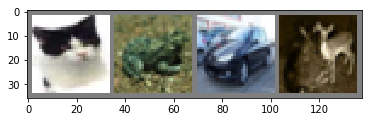

In [109]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
# functions to show an image

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [110]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [111]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [114]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 0.985
[1,  4000] loss: 1.031
[1,  6000] loss: 1.019
[1,  8000] loss: 1.025
[1, 10000] loss: 1.016
[1, 12000] loss: 1.030
[2,  2000] loss: 0.920
[2,  4000] loss: 0.942
[2,  6000] loss: 0.966
[2,  8000] loss: 0.957
[2, 10000] loss: 0.976
[2, 12000] loss: 0.985
Finished Training


GroundTruth:    cat  ship  ship plane


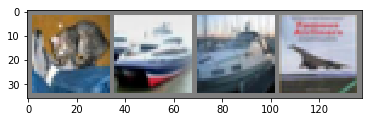

In [115]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [117]:
images.size()

torch.Size([4, 3, 32, 32])

In [119]:
outputs = net(images)
outputs.size()

torch.Size([4, 10])

In [120]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat  ship  ship plane


In [124]:
outputs,predicted

(tensor([[-1.1308, -2.7844,  0.3069,  2.9584,  0.1551,  1.1610,  1.9089, -3.0522,
           1.7331, -2.2465],
         [ 4.8830,  4.7053, -2.6357, -3.6265, -3.0414, -4.7830, -3.9929, -4.3736,
           6.7996,  4.4569],
         [ 2.8610,  2.7156, -1.2454, -0.9701, -2.5472, -1.8551, -2.8836, -3.2811,
           5.5260,  2.2511],
         [ 6.1021, -0.8274,  1.8047, -2.7140, -0.0092, -3.5047, -2.4175, -3.2508,
           3.5294, -0.3332]], grad_fn=<ThAddmmBackward>), tensor([3, 8, 8, 0]))

In [125]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 63 %


In [126]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 68 %
Accuracy of   car : 74 %
Accuracy of  bird : 49 %
Accuracy of   cat : 38 %
Accuracy of  deer : 60 %
Accuracy of   dog : 50 %
Accuracy of  frog : 76 %
Accuracy of horse : 69 %
Accuracy of  ship : 79 %
Accuracy of truck : 74 %


In [127]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Assume that we are on a CUDA machine, then this should print a CUDA device:
print(device)

cuda:0


In [128]:
net.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [129]:
inputs, labels = inputs.to(device), labels.to(device)

# ULMFiT
1. 通过atec + wiki语料训练语言模型
-  省略atec语料的finetune
2. 将语言模型的结果作为embedding，实现分类器后端，进行迁移学习

## 准备训练文本内容（char level）

In [ ]:
def transfrom_wiki2ids(dtype):
    n_tokens = 100000
    train_array, val_array = [],[]
    if dtype=="char":
        wiki = WikiChars()
    else:
        wiki = WikiWords()

    with open(model_dir + "lm_%s_train.csv"%dtype, 'w', encoding="utf8") as train_file:
        length = 0
        for line in wiki:
            train_file.write(" ".join(line)+"\n")
            length += len(line)
            if length>n_tokens:
                break
    with open(model_dir + "lm_%s_valid.csv"%dtype, 'w', encoding="utf8") as valid_file:
        length = 0
        for line in wiki:
            valid_file.write(" ".join(line)+"\n")
            length += len(line)
            if length>n_tokens//10:
                break
                
for dtype in ["char", "word"]:
    transfrom_wiki2ids(dtype)

In [ ]:
wd=1e-7
bptt=70
bs=52
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))
trn_dl = LanguageModelLoader(np.concatenate(trn_lm), bs, bptt)
val_dl = LanguageModelLoader(np.concatenate(val_lm), bs, bptt)
md = LanguageModelData(PATH, 1, vs, trn_dl, val_dl, bs=bs, bptt=bptt)
drops = np.array([0.25, 0.1, 0.2, 0.02, 0.15])*0.7
learner= md.get_model(opt_fn, em_sz, nh, nl, 
    dropouti=drops[0], dropout=drops[1], wdrop=drops[2], dropoute=drops[3], dropouth=drops[4])
learner.metrics = [accuracy]

# finetune语言模型训练最后一层，包含embedding权重，这会是使
# 在原语料(wiki103)中不存在的词获得更好的权重
learner.freeze_to(-1)
learner.model.load_state_dict(wgts)
lr=1e-3
lrs = lr
learner.fit(lrs/2, 1, wds=wd, use_clr=(32,2), cycle_len=1)
learner.save('lm_last_ft')
# 解锁所有层，精调整个语言模型
learner.load('lm_last_ft')
learner.unfreeze()
learner.lr_find(start_lr=lrs/10, end_lr=lrs*10, linear=True)
learner.sched.plot()
learner.fit(lrs, 1, wds=wd, use_clr=(20,10), cycle_len=15)
learner.save('lm1')

learner.save_encoder('lm1_enc')
learner.sched.plot_loss()